# Оценка результатов А/В-теста

В нашем распоряжении датасет с действиями пользователей, несколько вспомогательных датасетов и техническое задание.

Цель исследования: оценить корректность проведения теста и проанализировать его результаты.

Техническое задание:

    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Ожидаемое количество участников теста: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    - конверсии в просмотр карточек товаров — событие product_page
    - просмотры корзины — product_cart
    - покупки — purchase.
    
Декомпозиция:

1 Загрузим данные и подготовим их к анализу

    1.1. Выгрузим данные
    1.2 Преобразуем тип данных в формат даты и времени
2 Оценим корректность проведения теста

    2.1 Выделим пользователей участвующих в тесте
    2.2 Проверим период набора пользователей в тест
    2.3 Проверим регион регистрации пользователей
    2.4 Проверим динамику набора пользователей в группы теста и проверьте равномерность распределения пользователей по группам теста и корректность их формирования
    2.5 Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно
3 Изучим данные о пользовательской активности

    3.1 Даты совершения событий участниками теста: совпадают ли они с датами проведения теста, согласно техническому заданию
    3.2 Активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке; если есть пользователи, которые не совершали событий после регистрации, изучите их количество и распределение между группами теста; сделайте вывод о необходимости учитывать пользователей без событий при изучении результатов теста
    3.3 Горизонт анализа: рассчитайте лайфтайм совершения события пользователем после регистрации, оставьте только те события, которые были совершены в первые 14 дней с момента регистрации; проверьте, что все участники теста имели возможность совершать события все 14 дней с момента регистрации, оцените когда пользователи совершают свои первые события каждого вида.
    3.4 Представьте развернутый вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%
4 Исследовательский анализ данных

    4.1 Распределение количества событий на пользователя в разрезе групп теста: постройте гистограмму распределения этой величины в разрезе групп и сравните её средние значения между собой у групп теста
    4.2 Динамика количества событий в группах теста по дням: изучите распределение числа событий по дням и сравните динамику групп теста между собой
    4.3 Убедитесь, что время проведения теста не совпадает с маркетинговыми и другими активностями. Настройте автоматическую проверку, выдающую список событий, пересекающихся с тестом. При необходимости оцените воздействие маркетинговых событий на динамику количества событий.
    4.4 Продуктовая воронка: постройте простые продуктовые воронки для двух групп теста с учетом логической последовательности совершения событий; изучите изменение конверсии в продуктовой воронке тестовой группы, по сравнению с контрольной: наблюдается ли ожидаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А?
    4.5 Общий вывод об изменении пользовательской активности в тестовой группе, по сравнению с контрольной
5 Оценка результатов A/B-тестирования

    5.1 Проверьте статистическую разницу долей z-критерием.
6 Общие выводы и рекомендации

## Загрузим данные и подготовим их к анализу

### Выгрузим данные

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go

In [2]:
def open_data(data):
    display(data.head())
    display(data.info())
    print('Пропущенных значений:\n', data.isna().sum())
    print('Пропущенных значений в %:\n', data.isna().mean()*100)
    print('Явных дубликатов:', data.duplicated().sum())

In [3]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [4]:
datasets = [marketing_events, new_users, events, participants]

for data in datasets:
    open_data(data)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Пропущенных значений:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Пропущенных значений в %:
 name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64
Явных дубликатов: 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Пропущенных значений:
 user_id       0
first_date    0
region        0
device        0
dtype: int64
Пропущенных значений в %:
 user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64
Явных дубликатов: 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Пропущенных значений:
 user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Пропущенных значений в %:
 user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.751175
dtype: float64
Явных дубликатов: 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Пропущенных значений:
 user_id    0
group      0
ab_test    0
dtype: int64
Пропущенных значений в %:
 user_id    0.0
group      0.0
ab_test    0.0
dtype: float64
Явных дубликатов: 0


**Выводы** Основная информация о каждом датасете:
1) marketing_events - календарь маркетинговых событий на 2020 год. Содержит 4 столбца и 14 записей. Пропусков и явных дубликатов не обнаружено. Столбцы 'start_dt' и 'finish_dt' имеют тип данных object. Их необходимо переформатитровать в дату.

2) new_users - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года. Содержит 4 столбца и 61733 записей. Пропусков и явных дубликатов не обнаружено. Столбец 'first_date' необходимо переформатировать в формат даты. Также следует проверить период дат.

3) events - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. Содержит 4 столбца и 440317 записей. Пропущенных значений в столбце 'details' 85,75%. Этот столбец содержит дополнительные данные о событии. Пропуски означают отсуствие дополнительной информации. Пропуски заполнять не надо. Явных дубликатов не обнаружено. Столбец 'event_dt' необходимо изменить тип данных на дату и время.

4) participants - таблица участников тестов. Содержит 3 столбца и 18268 записей. Пропусков и явных дубликатов не обнаружено. Формат всех столбцов корректен, преобразования не требует.

### Преобразуем тип данных в формат даты и времени

In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

## Оценим корректность проведения теста

### Выделим пользователей участвующих в тесте

Посмотрим, сколько участников каждого теста в датасете participants.

In [6]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Согласно ТЗ наш тест называется 'recommender_system_test'. Выделим из таблицы участников тестов пользователей, участвующих в нашем тесте.

In [7]:
recommender_system_test = participants.query('ab_test == "recommender_system_test"')

print('В результате в таблице участников тестов осталось', recommender_system_test['user_id'].nunique(), 'участников.')

В результате в таблице участников тестов осталось 6701 участников.


### Проверим период набора пользователей в тест

Согласно ТЗ дата запуска теста 2020-12-07, дата остановки набора новых пользователей 2020-12-21.

In [8]:
print('Дата набора новых пользователей:', new_users['first_date'].min())

Дата набора новых пользователей: 2020-12-07 00:00:00


In [9]:
print('Дата остановки набора новых пользователей:', new_users['first_date'].max())

Дата остановки набора новых пользователей: 2020-12-23 00:00:00


Минимальная дата соответствует, а максимальная больше нужной. Удалим из датасета новых пользователей, которые зарегистрировались после 2020-12-21.

In [10]:
max_time = '2020-12-21'
new_users = new_users.query('first_date <= @max_time')

**Вывод:** Данные не соответствуют техническому заданию: дата остановки набора новых пользователей 2020-12-23, а по техническому заданию 2020-12-21. 

### Проверим регион регистрации пользователей

Отберем пользователей из таблицы new_users из целевого региона.

In [11]:
new_users = new_users.query('region == "EU"')

print('Общее количество пользователей из целевого региона EU составляет:', new_users['user_id'].nunique())

Общее количество пользователей из целевого региона EU составляет: 42340


Объединим таблицы participants и new_users и узнаем количество участников из целевого региона.

In [12]:
data = recommender_system_test.merge(new_users, on='user_id', how='inner')

print('Количество участников из целевого региона', data['user_id'].nunique(), 'что составляет,', data['user_id'].nunique()/new_users['user_id'].nunique()*100, '%.')

Количество участников из целевого региона 6351 что составляет, 15.0 %.


**Вывод:** Условие ТЗ, что ожидаемое количество участников теста 15% новых пользователей из региона EU, выполняется.

### Проверим динамику набора пользователей в группы теста и проверьте равномерность распределения пользователей по группам теста и корректность их формирования

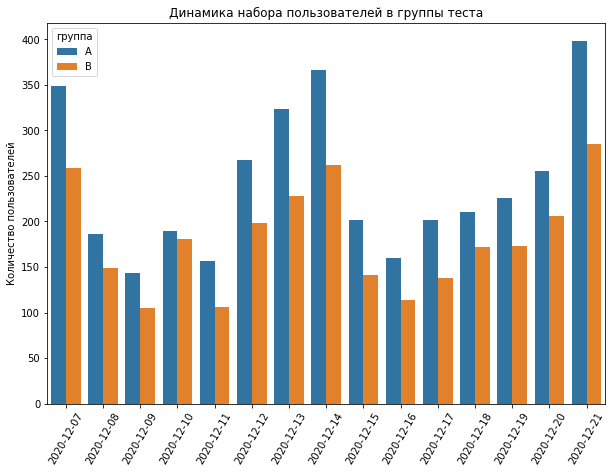

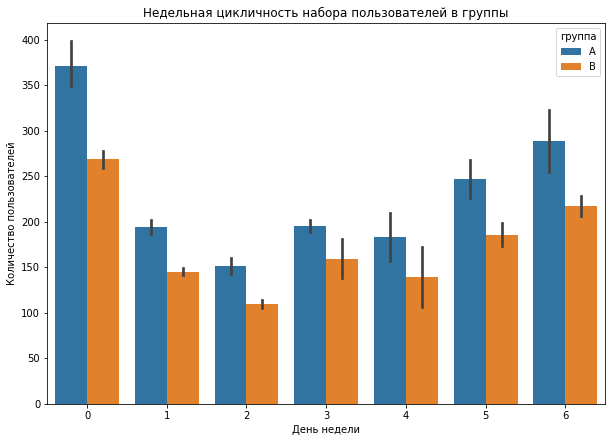

In [13]:
a_b_user_id = data.groupby(['first_date', 'group']).agg({'user_id':['count']}).reset_index()
a_b_user_id.columns = ['first_date', 'group', 'count']
a_b_user_id['weekday'] = a_b_user_id['first_date'].dt.weekday
a_b_user_id['first_date'] = pd.to_datetime(a_b_user_id['first_date']).dt.date

plt.figure(figsize=(10,7))
sns.barplot(x='first_date', y='count', hue='group', data=a_b_user_id)
plt.title('Динамика набора пользователей в группы теста')
plt.xlabel('')
plt.ylabel('Количество пользователей')
plt.legend(title='группа')
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(10,7))
sns.barplot(x='weekday', y='count', hue='group', data=a_b_user_id)
plt.title('Недельная цикличность набора пользователей в группы')
plt.xlabel('День недели')
plt.ylabel('Количество пользователей')
plt.legend(title='группа')
plt.show()

**Вывод:** Из графиков видно, что в группу А пользователей набиралось больше на протяжении всего периода. Больше всего пользователей набиралось в понедельник. В середине недели динамика падала, и увеличивалась к субботе и воскресенью.

### Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно

Выделим пользователей конкурирующего теста из группы В, так как на них оказывалось влияние в результате теста.

In [14]:
interface_eu_test_B = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]

Выделим в отдельный датасет пользователей из группы В конкурирующего тест, которые попали также в наш тест.

In [15]:
repeat_users = data[data['user_id'].isin(interface_eu_test_B['user_id'].values)]

Проанализируем как распределены группы А и В нашего теста. И узнаем, как пользователи из конкурируещего теста группы В распределены между группами нашего тест. 

In [16]:
a_b_group = (
    data
    .groupby('group')
    .agg({'user_id':'nunique'})
    .reset_index()
)

a_b_group

,group,user_id
0,A,3634
1,B,2717


In [17]:
bad_users = (
    data[data['user_id'].isin(repeat_users['user_id'])]
    .groupby('group')
    .agg({'user_id':'nunique'})
    .reset_index()
)

bad_users

,group,user_id
0,A,439
1,B,344


Проведем z-тест и проверим гипотезу о равенстве пропорций из пользователей группы В конкурирующего теста в группе А и В нашего теста.

Нулевая гипотеза (H0): Доли посетителей одинаковы.

Альтернативная гипотеза (H1): Доли посетитей не одинаковы.

In [18]:
alpha = 0.05

repeat_users = np.array([bad_users[bad_users['group']=='A']['user_id'], bad_users[bad_users['group']=='B']['user_id']])
system_test = np.array([a_b_group[a_b_group['group']=='A']['user_id'], a_b_group[a_b_group['group']=='B']['user_id']])

p1 = repeat_users[0]/system_test[0]


p2 = repeat_users[1]/system_test[1]

p_combined = (repeat_users[0] + repeat_users[1]) / (system_test[0] + system_test[1])

difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/system_test[0] + 1/system_test[1]))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  [0.48617918]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим нет ли пользователей, участвующих в двух тестах одновременно.

In [19]:
users = data.groupby('user_id').agg({'group':'nunique'})
bad_users = users.query('group > 1')
bad_users.shape[0]

0

Все верно, пользователи в каждой группе уникальны.

**Вывод:** Доли в двух группах распределены равномерно. Значит их влияние на поведение можно считать одинаковым в двух группах нашего теста. Оставим их для анализа.

## Изучим данные о пользовательской активности

### Даты совершения событий участниками теста: совпадают ли они с датами проведения теста, согласно техническому заданию

In [20]:
print('Самое раннее событие:', events['event_dt'].min())

Самое раннее событие: 2020-12-07 00:00:33


In [21]:
print('Самое позднее событие:', events['event_dt'].max())

Самое позднее событие: 2020-12-30 23:36:33


**Вывод:** Данные не соответствуют технического заданию: последнее событие в датасете за 2020-12-30 23:36:33, а в техническом задании окончание теста 2021-01-04.

### Активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке; если есть пользователи, которые не совершали событий после регистрации, изучите их количество и распределение между группами теста; сделайте вывод о необходимости учитывать пользователей без событий при изучении результатов теста

Найдем пользователей, которые не совершали никаких событий.

In [22]:
inactive_users = data[~(data['user_id'].isin(events['user_id']))]

print('Неактивных пользователей:', inactive_users['user_id'].nunique())
print('Доля неактивных пользователей: {:.2%}'.format(inactive_users['user_id'].nunique()/data['user_id'].nunique()))
print('Рспределены по группам:')
inactive_users.groupby('group').agg({'user_id':'nunique'})

Неактивных пользователей: 2870
Доля неактивных пользователей: 45.19%
Рспределены по группам:


,user_id
group,
A,1030
B,1840


In [23]:
print('Доля неактивных пользователей в группе А: {:.2%}'.format(inactive_users[inactive_users['group']== 'A']['user_id'].nunique()/
     data[data['group']== 'A']['user_id'].nunique()))

print('Доля неактивных пользователей в группе B: {:.2%}'.format(inactive_users[inactive_users['group']== 'B']['user_id'].nunique()/
     data[data['group']== 'B']['user_id'].nunique()))

Доля неактивных пользователей в группе А: 28.34%
Доля неактивных пользователей в группе B: 67.72%


Неактивных пользователей удалим из нашего анализа, так как они не прошли даже авторизацию, т.е. не участвовали в воронке продаж.

In [24]:
data = data[(data['user_id'].isin(events['user_id']))]

print('Активных пользователей осталось в тесте:', data['user_id'])

Активных пользователей осталось в тесте: 0       D1ABA3E2887B6A73
1       A7A3664BD6242119
2       DABC14FDDFADD29E
3       04988C5DF189632E
5       4FF2998A348C484F
              ...       
6346    7C5C12FA1B5AB710
6347    91C3969B8A72B908
6348    E26F13A65CEAC6EA
6349    95401934D6D6D4FC
6350    80712ED4EA1B52A5
Name: user_id, Length: 3481, dtype: object


**Вывод:** Неактивных пользователей оказалось 2870. Из них 28.34% - из группы А, и 67.72% - из группы В. После фильтрации в тесте осталось 3481 пользователей.

### Горизонт анализа: рассчитайте лайфтайм совершения события пользователем после регистрации, оставьте только те события, которые были совершены в первые 14 дней с момента регистрации; проверьте, что все участники теста имели возможность совершать события все 14 дней с момента регистрации, оцените когда пользователи совершают свои первые события каждого вида.

Отфильтруем таблицу с событиями и оставим события только наших активных пользователей. Затем присоединим таблицу events с событиями пользовтелей нашего теста.

In [25]:
events = events[events['user_id'].isin(data['user_id'])]

In [26]:
data = events.merge(data, on='user_id', how='left')

Добавим столбец с возрастом каждого события.

In [27]:
data['age_events'] = (data['event_dt'] - data['first_date']).dt.days
#event_age = data.groupby(['event_name', 'age_events']).agg({'age_events':'count'})
#event_age

Посмотрим какие виды событий есть в таблице.

In [28]:
data['event_name'].value_counts()

login           10595
product_page     6554
purchase         3196
product_cart     3075
Name: event_name, dtype: int64

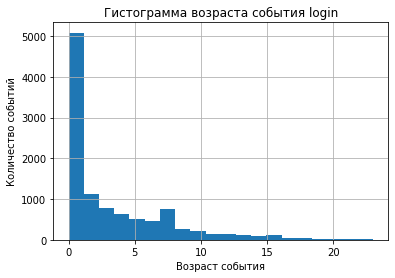

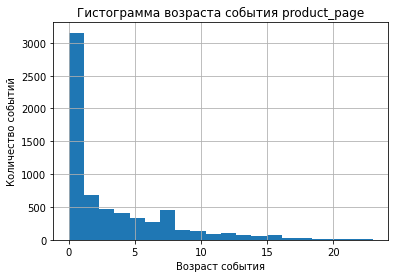

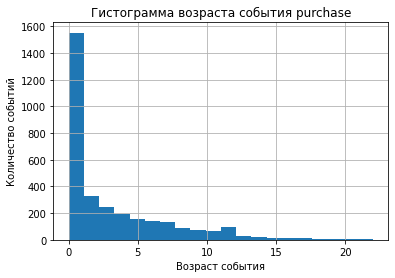

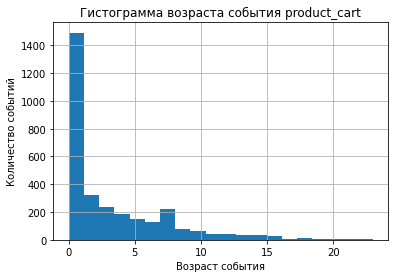

In [29]:
events_list = ['login', 'product_page', 'purchase', 'product_cart']

for event in events_list:
    data[data['event_name']==event]['age_events'].hist(bins=20)
    plt.title('Гистограмма возраста события '+ event)
    plt.ylabel('Количество событий')
    plt.xlabel('Возраст события')
    plt.show()

**Вывод:** Большинство событий совершается в первый день регистрации. По условиям ТЗ, нам нужно исключить события, которые старше 14 дней.

In [30]:
data = data[data['age_events'] < 15]

### Представьте развернутый вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%

In [31]:
print('Количество уникальных пользователей теста:', data['user_id'].nunique())

Количество уникальных пользователей теста: 3481


In [32]:
print('Они распределены по группам:')
data.groupby('group').agg({'user_id':'nunique'})

Они распределены по группам:


,user_id
group,
A,2604
B,877


In [33]:
print('Доля уникальных пользователей группы А: {:.2%}'.format(data[data['group']=='A']['user_id']\
                                                              .nunique()/data['user_id'].nunique()))

print('Доля уникальных пользователей группы B: {:.2%}'.format(data[data['group']=='B']['user_id']\
                                                              .nunique()/data['user_id'].nunique()))


Доля уникальных пользователей группы А: 74.81%
Доля уникальных пользователей группы B: 25.19%


In [34]:
print('Количество событий в датасете осталось:', len(data))

Количество событий в датасете осталось: 22828


**Выводы**

Соответствие данных техническому заданию: 
- дата остановки набора новых пользователей 2020-12-23, а по техническому заданию 2020-12-21;
- последнее событие в датасете за 2020-12-30 23:36:33, а в техническом задании окончание теста 2021-01-04;
- условие, что ожидаемое количество участников теста 15% новых пользователей из региона EU, выполняется
- события, старше 14 дней, были удалены.

В результате в датасете осталось 3481 уникальных пользователей, из которых 2604 из группы А (74%), 877 из группы В (25%). Количество событий 22828.

Размер выборки, при базовом показателе конверсии 50% и минимальном эффекте 5%: 5100 каждой группы. Наши выборки сильно меньше требуемых.

## Исследовательский анализ данных

### Распределение количества событий на пользователя в разрезе групп теста: постройте гистограмму распределения этой величины в разрезе групп и сравните её средние значения между собой у групп теста

Посмотрим, сколько событий в среднем приходится на пользователя.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


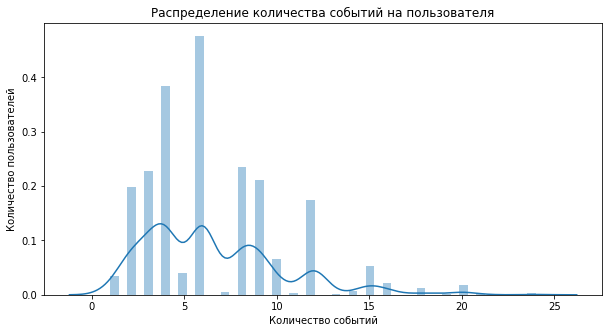

In [35]:
events_by_user = data.groupby('user_id').agg({'event_name':'count'}).reset_index()

plt.figure(figsize=(10, 5))
plt.title('Распределение количества событий на пользователя')
sns.distplot(events_by_user['event_name'], bins=50)
plt.xlabel('Количество событий')                  
plt.ylabel('Количество пользователей')             
plt.show()

**Вывод:** В среднем на пользователя приходится 6 событий.

Посмотрим, сколько событий в среднем приходится на пользователя каждой группы.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


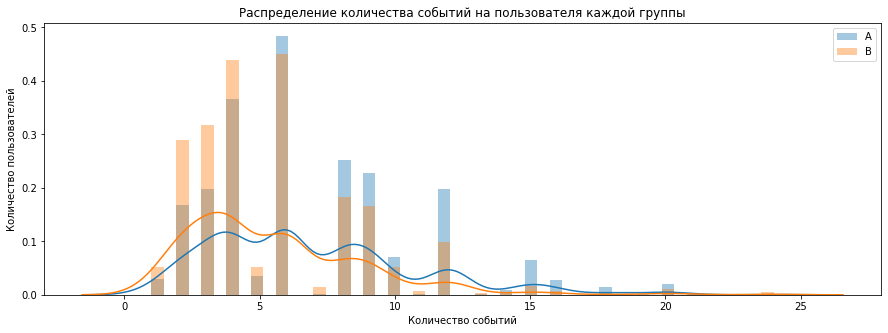

In [36]:
events_by_user_a = data[data['group'] == 'A'].groupby('user_id').agg({'event_name':'count'}).reset_index()
events_by_user_b = data[data['group'] == 'B'].groupby('user_id').agg({'event_name':'count'}).reset_index()

plt.figure(figsize=(15, 5))
plt.title('Распределение количества событий на пользователя каждой группы')
sns.distplot(events_by_user_a['event_name'], bins=50, label='A')
sns.distplot(events_by_user_b['event_name'], bins=50, label='B')
plt.xlabel('Количество событий')                  
plt.ylabel('Количество пользователей')     
plt.legend()
plt.show()

**Вывод:** В группе А наблюдается пик в районе 6, в группе В - пик в районе 3 событий на пользователя.

Создадим дополнительный столбец, в котором будет посчитано количество событий на пользователя.

In [37]:
data['cnt_events'] = data.groupby('user_id')['event_name'].transform('count')

Сравним средние значения количества событий на пользователя между собой у групп теста.

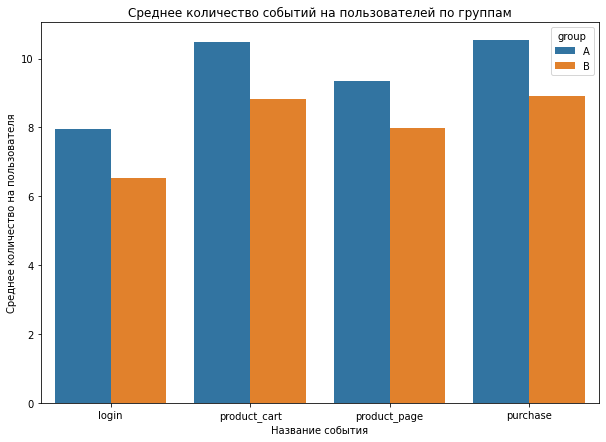

In [38]:
mean_event = data.groupby(['event_name', 'group']).agg({'cnt_events':'mean'}).reset_index()

plt.figure(figsize=(10,7))
sns.barplot(x='event_name', y='cnt_events', hue='group', data=mean_event)
plt.title('Среднее количество событий на пользователей по группам')
plt.xlabel('Название события')
plt.ylabel('Среднее количество на пользователя')
plt.show()

**Вывод:** На графике видно, что в среднем пользователи группы А совершают всех событий больше, чем пользователи группы В.

### Динамика количества событий в группах теста по дням: изучите распределение числа событий по дням и сравните динамику групп теста между собой

Создадим отдельный столбец с днем месяца.

In [39]:
data['day'] = pd.DatetimeIndex(data['event_dt']).day

Посчитаем процент событий от общего числа событий в группе и посмотрим на динамику по дням.

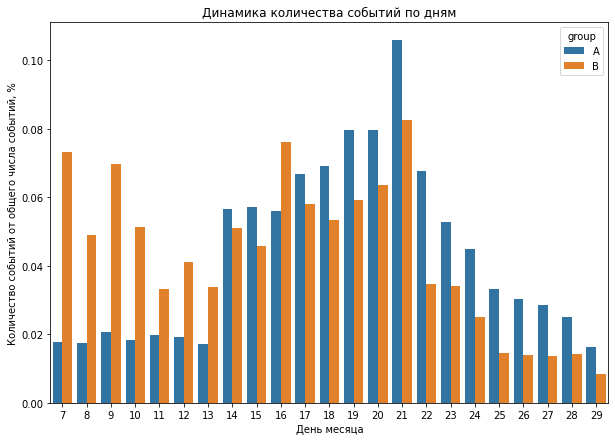

In [40]:
dynamics = data.groupby(['day', 'group']).agg({'event_name':'count'}).reset_index()
dynamics['total'] = dynamics.groupby('group')['event_name'].transform('sum')
dynamics['%'] = dynamics['event_name']/dynamics['total']

plt.figure(figsize=(10,7))
sns.barplot(x='day', y='%', hue='group', data=dynamics)
plt.title('Динамика количества событий по дням')
plt.xlabel('День месяца')
plt.ylabel('Количество событий от общего числа событий, %')
plt.show()

**Вывод:** До 14 числа пик событий приходится на группу В, а с 14-го пик событий на группу А. После 21 наблюдается общий спад динамики событий. Спад скорее всего связан с прекращением набора новых пользователей.

Рассмотрим динамику набора новых пользователей

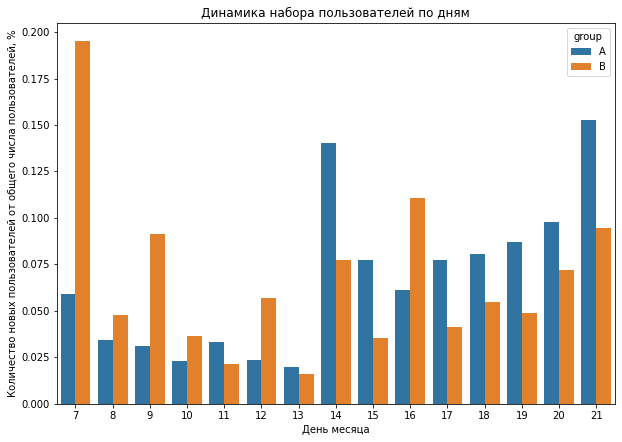

In [41]:
data['day_first'] = pd.DatetimeIndex(data['first_date']).day

dynamics_new_users = data.groupby(['day_first', 'group']).agg({'user_id':'nunique'}).reset_index()
dynamics_new_users['total'] = dynamics_new_users.groupby('group')['user_id'].transform('sum')
dynamics_new_users['%'] = dynamics_new_users['user_id']/dynamics_new_users['total']

plt.figure(figsize=(10,7))
sns.barplot(x='day_first', y='%', hue='group', data=dynamics_new_users)
plt.title('Динамика набора пользователей по дням')
plt.xlabel('День месяца')
plt.ylabel('Количество новых пользователей от общего числа пользователей, %')
plt.show()

**Вывод:** Можем сделать вывод, пик событий с 14-го числа связан с пиком набора новых пользователей.

### Убедитесь, что время проведения теста не совпадает с маркетинговыми и другими активностями. Настройте автоматическую проверку, выдающую список событий, пересекающихся с тестом. При необходимости оцените воздействие маркетинговых событий на динамику количества событий.

Найдем акции, которые проходили в этот же период и в том же регионе.

In [42]:
data_start = '2020-12-07'
data_end = '2020-12-29'
EU = 'EU'

promo = marketing_events[(marketing_events['start_dt'] <= data_end)\
                        &(marketing_events['finish_dt'] >= data_start)\
                        &(marketing_events['regions'].str.contains('EU'))]

promo

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


распределение событий по датам с разбиением по группам. по оси х - даты, у - количество событий в эти даты

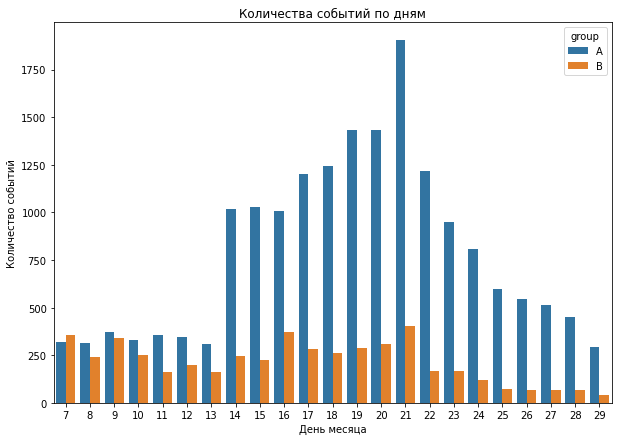

In [43]:
cnt_day = data.groupby(['day', 'group']).agg({'event_name':'count'}).reset_index()

plt.figure(figsize=(10,7))
sns.barplot(x='day', y='event_name', hue='group', data=cnt_day)
plt.title('Количества событий по дням')
plt.xlabel('День месяца')
plt.ylabel('Количество событий')
plt.show()

**Вывод:** Наш тест пересекается с новогодней акцией, которая началась 25 декабря и закончилась 3 января. На графике видно, что изменений активности в эти датыне наблюдается. Можем сделать вывод, что акция ни какого влияния не оказала.

### Продуктовая воронка: постройте простые продуктовые воронки для двух групп теста с учетом логической последовательности совершения событий; изучите изменение конверсии в продуктовой воронке тестовой группы, по сравнению с контрольной: наблюдается ли ожидаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А?

Построим воронку продаж с разбиением по группам. События выстроим в логической последовательности:

1. 'login' - авторизация
2. 'product_page' - просмотр товара
3. 'product_cart' - просмотр корзины
4. 'purchase' - покупка

In [44]:
funnel = (data
          .groupby(['event_name', 'group'])
          .agg({'user_id': 'nunique'})
          .reset_index()
          .sort_values(by=['group','user_id'], ascending=False))

funnel = funnel.reindex([0,1,4,5,2,3,6,7])

funnel 

,event_name,group,user_id
0,login,A,2604
1,login,B,876
4,product_page,A,1685
5,product_page,B,493
2,product_cart,A,782
3,product_cart,B,244
6,purchase,A,833
7,purchase,B,249


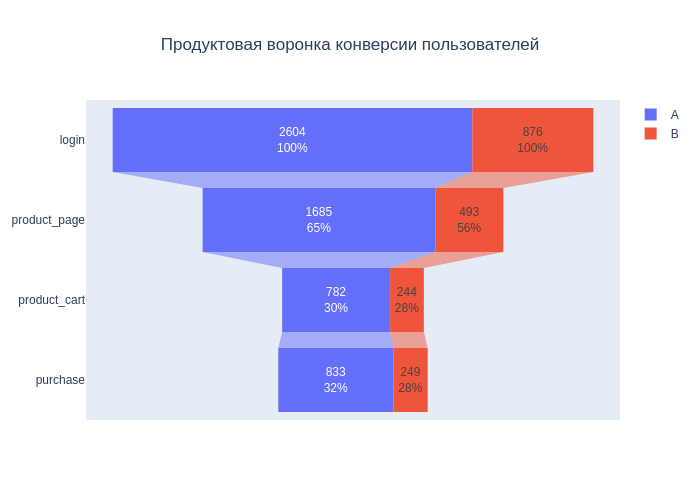

In [45]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'A',
                        y = funnel.query('group == "A"')['event_name'],
                        x = funnel.query('group == "A"')['user_id'],
                        textposition = 'inside',
                        textinfo = 'value + percent initial'))

fig.add_trace(go.Funnel(name = 'B',
                        y = funnel.query('group == "B"')['event_name'],
                        x = funnel.query('group == "B"')['user_id'],
                        textposition = 'inside',
                        textinfo = 'value + percent initial'))
                        
fig.update_layout(title_text='Продуктовая воронка конверсии пользователей', title_x=0.5)
fig.show(renderer='png', width=700, heiqht=450, scale=None)

**Вывод:** Ожидиаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А, не наблюдается. На данном графике можно увидеть падение конверсии в группе В на каждом шаге:
- 'просмотр товара' падение на 9%
- 'просмотр корзины' падение на 2%
- 'покупка' падение на 4%.

### Общий вывод об изменении пользовательской активности в тестовой группе, по сравнению с контрольной

В среднем на пользователя приходится 6 событий. В группе А наблюдается пик в районе 6, в группе В - пик в районе 3 событий на пользователя. В среднем пользователи группы А совершают всех событий больше, чем пользователи группы В.

До 14 числа пик событий приходится на группу В, а с 14-го пик событий на группу А. После 21 наблюдается общий спад динамики событий. Спад скорее всего связан с прекращением набора новых пользователей.

Наш тест пересекается с новогодней акцией, которая началась 25 декабря и закончилась 3 января. На графике видно, что изменений активности в эти датыне наблюдается. Можем сделать вывод, что акция ни какого влияния не оказала.

Ожидиаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А, не наблюдается. На данном графике можно увидеть падение конверсии в группе В на каждом шаге:
- 'просмотр товара' падение на 9%
- 'просмотр корзины' падение на 2%
- 'покупка' падение на 4%.

## Оценка результатов A/B-тестирования

### Проверьте статистическую разницу долей z-критерием.

Проверим, чтобы каждый пользователь принадлежал только к одной группе.

In [46]:
users = data.groupby('user_id').agg({'group':'nunique'})
bad_users = users.query('group > 1')
bad_users.shape[0]

0

Все верно, пользователи в каждой группе уникальны.

Проверим 3 гипотезы о равенстве долей в группах А и В при конверсии:
- 'просмотр товара'
- 'просмотр корзины'
- 'покупка'

Н<sub>0</sub>: Доли уникальных посетителей на этапе воронки одинаковы. 

Н<sub>1</sub>: Доли уникальных посетителей на этапе воронки различаются.


Мы проводим множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Сделаем поправку по Бонферрони.

In [47]:
alpha = 0.05
bonferroni_alpha = alpha / 3
        
#Создадим функцию для сравнения конверсий между группами:
def compare_group(data1, data2, event):
    
    users = np.array([data1['user_id'].nunique(), 
                        data2['user_id'].nunique()])
    
    success = np.array([data1[data1['event_name'] == event]['user_id'].nunique(), 
                        data2[data2['event_name'] == event]['user_id'].nunique()])
    
    p1 = success[0]/users[0]
    p2 = success[1]/users[1]
    
    print(users[0], users[1])
    
    p_combined = (success[0] + success[1]) / (users[0] + users[1])
    
    difference = p1 - p2 
    
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))
    
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   
    
    print('Результаты теста для события:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    

In [48]:
list_events = ['product_page', 'product_cart', 'purchase']

for event in list_events:
    compare_group(data[data['group'] == 'A'], data[data['group'] == 'B'], event)
    

2604 877
Результаты теста для события: product_page
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу: между долями есть разница
2604 877
Результаты теста для события: product_cart
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
2604 877
Результаты теста для события: purchase
p-значение:  0.04652482738393027
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** По рузельтатам z-теста разница в долях обнаружилась только на этапе просмотра карточки товара. Как мы выяснили ранее, на этом этапе конверсия упала на 9%. На этапах корзины и покупки значимой разницы нет.

## Общие выводы и рекомендации

В результате предобработки в датасете осталось 3481 уникальных пользователей, из которых 2604 из группы А (74%), 877 из группы В (25%). Количество событий 22828.


Тест был проведен с нарушениями:
- дата остановки набора новых пользователей 2020-12-23, а по техническому заданию 2020-12-21;
- последнее событие в датасете за 2020-12-30, а в техническом задании окончание теста 2021-01-04;
- параллельно с нашим тестом шел другой тест, аудитории теста пересекались. Но мы оставили их для анализа, так как из количество распределено равномерно в наших группах А и В;
- количество участников А(2604) и В(877) сильно различаются;
- доля неактивных пользователей составила 45%, которые не совершили даже авторизацию.


Данные факторы могли повлиять на результаты теста. Рекомендуется учесть замечания и обновить механизм формирования тестовых групп. Также рекомендуется запускать тест, предварительно изучив календарь маркетинговых акций.

Ислледовательский анализ был проведен на имеющихся данных. 

В среднем на пользователя приходится 6 событий. В группе А наблюдается пик в районе 6, в группе В - пик в районе 3 событий на пользователя. В среднем пользователи группы А совершают всех событий больше, чем пользователи группы В.

До 14 числа пик событий приходится на группу В, а с 14-го пик событий на группу А. Пик событий с 14-го числа связан с пиком набора новых пользователей. После 21 наблюдается общий спад динамики событий. Спад скорее всего связан с прекращением набора новых пользователей.

Наш тест пересекается с новогодней акцией, которая началась 25 декабря и закончилась 3 января. На графике видно, что изменений активности в эти датыне наблюдается. Можем сделать вывод, что акция ни какого влияния не оказала.

Ожидаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А, не наблюдается. На данном графике можно увидеть падение конверсии в группе В на каждом шаге:
- 'просмотр товара' падение на 9%
- 'просмотр корзины' падение на 2%
- 'покупка' падение на 4%.


По результатам z-теста разница в долях обнаружилась только на этапе просмотра карточки товара. Как мы выяснили ранее, на этом этапе конверсия упала на 9%. На этапах корзины и покупки значимой разницы нет.

Изменения, связанные с внедрением улучшенной рекомендательной системы, **не дали** ожидаемый эффект в улучшении каждой метрики не менее, чем на 5 процентных пунктов за 14 дней с момента регистрации в системе.

Результаты теста можно засчитать. Ожидаемый эффект не достигнут. Не имеет смысла тратить средства и проводить тест заново.